In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit
import networkx as nx

import itertools

from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import tensorflow as tf

In [3]:
from common.adjacency_list_to_graph import build_graph
from common.calculate_spring_rank import calculate_spring_rank
from common.graph_to_matrix import build_matrix

In [4]:
transactions_df = pd.read_csv("./part_data", sep=" ", names=["from", "to", "value", "block"])
transactions_df["value"] = 1
transactions_df = transactions_df.sort_values("block")

Для теста используем граф с выраженной иерархией, например, граф цитат

In [86]:
transactions_df = pd.read_csv("./twitter_combined.txt", sep=" ", names=["from", "to"])
transactions_df["value"] = 1

In [87]:
def create_dataset(dataset, addresses=None):
    if addresses:
        dataset = dataset[dataset["from"].isin(addresses) & dataset["to"].isin(addresses)]
    return dataset.groupby(["from", "to"])["value"].sum().to_frame()

In [88]:
def find_ranks(dataset, alpha):
    edges = dataset["value"].to_dict()
    graph = build_graph(edges)
    nodes = list(graph)
    A = build_matrix(graph, nodes)
    iterations, raw_rank = calculate_spring_rank(A, alpha=alpha)
    
    rank = pd.DataFrame()
    rank["address"] = nodes
    rank["rank"] = raw_rank
    
    return rank.set_index("address")

Модель предсказания дуг:
$$P_{ij} = \frac{1}{1 + e^{-2\beta(s_i - s_j)}}$$
$$P_{ji} = \frac{1}{1 + e^{2\beta(s_i - s_j)}} $$
$$P_{ij} = 1 - P_{ji}$$

$$E_{ij} = c \exp{-\frac{\beta}{2}(s_i - s_j - 1)^2}$$

In [89]:
# def predict_edges(dataset, ranks, beta):
#     dataset["from_rank"] = ranks.loc[[a for a, _ in dataset.index]]["rank"].tolist()
#     dataset["to_rank"] = ranks.loc[[b for _, b in dataset.index]]["rank"].tolist()
#     return (1 / (1 + np.exp(-2 * beta * (dataset["from_rank"] - dataset["to_rank"])))).tolist()

In [90]:
s = tf.Session()

In [97]:
def predict_edges_sum(dataset, ranks, beta, c):
    addresses = set([a for a, _ in dataset.index] + [b for _, b in dataset.index])
    ranks = ranks.loc[addresses]["rank"].tolist()
    dataset_shape = len(ranks)
    batch_shape = 10000
    assert dataset_shape*batch_shape <= 10000000*1000
    ranks_tensor = tf.placeholder(tf.float64, shape=[None, ])
    dataset = tf.data.Dataset.from_tensor_slices(ranks_tensor)
    dataset = dataset.batch(batch_shape)
    dataset = dataset.map(lambda x: tf.reduce_sum(c*tf.exp(-beta / 2. * (tf.transpose([x]) - ranks_tensor - 1) ** 2)))

    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    s.run(iterator.initializer, {ranks_tensor: ranks})
    total_sum = 0
    count = 0
    
    while True:
        count += 1
        print("{} of {}".format(count, dataset_shape // batch_shape), end="\r")
        try:
            total_sum += s.run(next_element)
        except tf.errors.OutOfRangeError:
            break
    return total_sum / 2

Находим $\beta$, максимизируя выражение:
$$L(A|s, \beta) = -\beta H(s) - M \log\sum_{i, j}\exp -\frac{\beta}{2}(s_i - s_j - 1)^2$$

In [296]:
def calculate_energy(dataset, ranks):
    dataset["from_rank"] = ranks["rank"].loc[[a for a, _ in dataset.index]].tolist()
    dataset["to_rank"] = ranks["rank"].loc[[b for _, b in dataset.index]].tolist()
    dataset["energy"] = (dataset["from_rank"] - dataset["to_rank"] - 1) ** 2
    return (dataset["value"] * dataset["energy"]).sum() / 2

def infer_temperature(dataset, ranks):
    H = calculate_energy(dataset, ranks)
    ranks = ranks["rank"].tolist()
    M = float(dataset["value"].sum())
    ranks_placeholder = tf.placeholder(tf.float64, shape=(None, ))
    beta_variable = tf.Variable(0, name="beta", dtype=tf.float64)
    
    dataset_shape = len(ranks)
    batch_shape = 10000
    num_epochs = 10
    dataset = tf.data.Dataset.from_tensor_slices(ranks_placeholder)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_shape)
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.map(lambda x: tf.reduce_sum(tf.exp(- 0.5 * beta_variable * (tf.transpose([x]) - ranks_placeholder - 1) ** 2)))
    
    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()
    
    # Should use partial H
    loss = - H * beta_variable - M * next_element
    optimizer = tf.train.AdagradOptimizer(100).minimize(loss)
    
    s.run(tf.global_variables_initializer())
    s.run(iterator.initializer, {ranks_placeholder: ranks})
    for i in tqdm_notebook(range(0, 100)):
        try:
            s.run(optimizer)
            print(s.run(loss))
        except tf.errors.OutOfRangeError:
            break
    return s.run(beta_variable)

In [297]:
infer_temperature(train, ranks)

-93119459927201.06
-71249265805139.06
-61690718937973.12
-56052882271504.05
-52457559623639.74
-49704241839703.62
-47656688606911.484
-44994848594236.664
-3292164704219.66
-41106954865877.45
-40142458671391.92
-39788410248470.74
-38257001050938.25
-37897530168076.13
-37300493221973.26
-36737252574297.71
-35890092477488.445
-2957224118980.5215
-33897439067087.363
-33460693847727.207
-33440243242764.16
-32985610305201.465
-32624426436113.887
-32834681391125.78
-32322848307612.02
-31897190439646.836
-2400647043988.5366
-30679575317117.766
-30005821772849.668
-30002663433164.035
-30053921836970.25
-29946851971736.56
-29792479406610.14
-29016650000783.273
-29500323520175.848
-2338738937260.864
-27947677898471.656
-27978448130693.83
-27914532429968.156
-27970796258974.98
-28134636788309.055
-27604103248428.875
-27855848999047.87
-27378689454382.906
-2061209118431.0166
-26354272315922.023
-26267833285919.17
-26443246841051.15
-26439449599912.145
-26227971170082.742
-26443833367336.387
-259431

1767.07957633377

Находим $c$, получая общее количество дуг (исходя из известного $\beta$)

In [143]:
def infer_density(dataset, ranks, beta):
    edges_sum = predict_edges_sum(dataset, ranks, beta, 1)
    return dataset["value"].sum() / edges_sum

In [282]:
def predict_edges(dataset, ranks, beta, c):
    dataset["from_rank"] = ranks.loc[[a for a, _ in dataset.index]]["rank"].tolist()
    dataset["to_rank"] = ranks.loc[[b for _, b in dataset.index]]["rank"].tolist()
    dataset["direction_probability"] = (1 / (1 + np.exp(-2 * beta * (dataset["from_rank"] - dataset["to_rank"]))))
    dataset["number_of_edges"] = c * np.exp(- beta / 2 * (dataset["from_rank"] - dataset["to_rank"] - 1) ** 2)
    return dataset["direction_probability"].tolist(), dataset["number_of_edges"].tolist(), predict_edges_sum(dataset, ranks, beta, c)

Количество дуг вычисляется следующим образом:

Ранги сортируются по возрастанию, $s_1$ - наибольший

$$f(i, j) = (s_i - s_j - 1)$$
$$g(i) = (s_i - s_{i+1})$$

Можно ли вычислить это за $O(1)$ по памяти и $O(n)$ по времени?

$$E_{1j} = c\exp{-\frac{\beta}{2}(s_1 - s_j - 1)^2} = c\exp{-\frac{\beta}{2}f(1, j)^2}$$
$$
E_{2j} = c\exp{-\frac{\beta}{2}(s_2 - s_j - 1)^2}
= c\exp{-\frac{\beta}{2}((s_1 - s_j - 1) - (s_1 - s_2))^2} 
= c\exp{-\frac{\beta}{2}((s_1 - s_j - 1)^2 - 2(s_1 - s_j - 1)(s_1 - s_2) + (s_1 - s_2)^2}
= c\exp{-\frac{\beta}{2}f(1, j)^2 - f(1, j)g(1) + g(1)^2}
$$

$$c\exp{-\frac{\beta}{2}f(2, j)^2} = c\exp{-\frac{\beta}{2}f(1, j)^2 - f(1, j)g(1) + g(1)^2}$$

$$-\frac{\beta}{2}f(2, j)^2= -\frac{\beta}{2}f(1, j)^2 - f(1, j)g(1) + g(1)^2$$

$$f(2, j)^2 = f(1, j)^2 - f(1, j)g(1) + g(1)^2$$

$$
f(2, j) = \pm\sqrt{f(1, j)^2 - f(1, j)g(1) + g(1)^2}
$$

$$
f(i + 1, j) = \pm\sqrt{f(i, j)^2 - f(i, j)g(i) + g(i)^2}, j > i + 1
$$

Если $f(i, j) < 0, т.е. s_i - s_j > 1$, то используется $-$, иначе $+$

Multigraph accuracy:
$$\sigma_a = 1 - \frac{1}{2M}\sum_{i,j}|{A_{ij} - (A_{ij} + A_{ji})P_{ij}}|$$

M - сумма всех весов

Как пропустить ошибку для отсутствующих дуг?
- Если Aij = 0 и Aji = 0 - ошибку можно пропустить?
- Если Aij = 0 и Aji != 0
$$A^*_{ij} = A_{ij}$$
$$e_{ij} = |0 - A_{ji}(1 - P_{ji})| = A_{ji}(1 - P_{ij})$$
$$e_{ij} + e_{ji} = |A_{ji} - A_{ji}P_{ji}| + A_{ji} - A_{ji}P_{ij} = 2(A_{ji} - A_{ji}P_{ij}) $$
Т.е. для непарных дуг удваиваем ошибку

Предполагается, что:
$$A_{ij} = 0, A_{ji} = 0 \rightarrow P_{ij} = 0, P_{ji} = 0$$

Есть ли возможность проверять предсказанное количество дуг?

Есть, если вместо Aij + Aji использовать
$$E_{ij} = c \exp{-\frac{\beta}{2}(s_i - s_j - 1)^2}$$

А вместо 2M?
$$ M + \sum_{ij}E_{ij} $$

Для случая $A_{ji} = 0, A_{ij} \neq 0$:

$$E_{ji}(1 - P_{ji}) + |A_{ji} - E_{ji}P_{ji}|$$

Для случая $A_{ij} = A_{ji} = 0$

$$E_{ij}$$

Т.е. сумма таких ошибок:

$$\sum E_{ij} - \frac{\sum_{(i,j), (j,i) \in G} E_{ij}}{2} - \sum_{(i,j) \in G, (j, i) \in G} E_{ij}$$

In [99]:
# def accuracy(dataset, predictions):
#     accuracy_dataset = dataset.copy()
#     accuracy_dataset = accuracy_dataset.merge(accuracy_dataset.reset_index(), left_index=True, right_on=["to", "from"], how="left", suffixes=('', '_reversed'))
#     accuracy_dataset["prediction"] = predictions
#     accuracy_dataset["total_value"] = accuracy_dataset["value"] + accuracy_dataset["value_reversed"].fillna(0)
#     accuracy_dataset["paired"] = accuracy_dataset["value"] < accuracy_dataset["total_value"]
#     accuracy_dataset["error"] = accuracy_dataset["value"] - accuracy_dataset["total_value"] * accuracy_dataset["prediction"]
#     accuracy_dataset.loc[~accuracy_dataset["paired"], "error"] *= 2
#     return 1 - np.abs(accuracy_dataset["error"]).sum() / 2 / accuracy_dataset["value"].sum()

In [100]:
def accuracy(dataset, direction, edges, edges_sum):
    accuracy_dataset = dataset.copy()
    accuracy_dataset = accuracy_dataset.merge(accuracy_dataset.reset_index(), left_index=True, right_on=["to", "from"], how="left", suffixes=('', '_reversed'))
    accuracy_dataset["not_paired"] = 0
    accuracy_dataset.loc[np.isnan(accuracy_dataset["value_reversed"]), "not_paired"] = 1
    accuracy_dataset["direction"] = direction
    accuracy_dataset["edges"] = edges
    accuracy_dataset["prediction"] = accuracy_dataset["direction"] * accuracy_dataset["edges"]
    accuracy_dataset["error"] = np.abs(accuracy_dataset["value"] - accuracy_dataset["prediction"])
    accuracy_dataset["non_paired_error"] = accuracy_dataset["not_paired"] * accuracy_dataset["edges"] * (1 - accuracy_dataset["direction"])
    non_active_edges_sum = edges_sum - (accuracy_dataset["not_paired"] * accuracy_dataset["edges"]).sum() - ((1 - accuracy_dataset["not_paired"]) * accuracy_dataset["edges"]).sum() / 2
    return 1 - \
        (accuracy_dataset["error"].sum() + accuracy_dataset["non_paired_error"].sum() + non_active_edges_sum) / \
        (accuracy_dataset["value"].sum() + edges_sum) 

In [101]:
test_df = pd.DataFrame()
test_df["from"] = ["0x1", "0x2", "0x3"]
test_df["to"] = ["0x2", "0x1", "0x4"]
test_df["value"] = [1, 2, 1]
test_df = test_df.set_index(["from", "to"])

In [139]:
test.shape[0] / test_sum

0.5574094865576852

In [135]:
1908465612

1908465612

In [154]:
alphas = [0]
# alphas = np.logspace(-2, 2, 5)
# cs = np.logspace(-2, 3, 10)
betas = np.linspace(100, 1000, 10)
split = ShuffleSplit(n_splits=5)
# split = TimeSeriesSplit(n_splits=5)

train_metrics = {}
test_metrics = {}

train_index, test_index = next(split.split(transactions_df))
# for train_index, test_index in :
train = create_dataset(transactions_df.loc[train_index])
print("Train size: {} samples".format(train.shape[0]))
train_addresses = list([a for a, _ in train.index] + [b for _, b in train.index])
test = create_dataset(transactions_df.loc[test_index], addresses=train_addresses)
print("Test size: {} samples".format(test.shape[0]))
for alpha in alphas:
    ranks = find_ranks(train, alpha=alpha)
    for beta in betas:
        c = infer_density(train, ranks, beta=beta)
        print(beta, c)
        train_directions, train_edges, train_sum = predict_edges(train, ranks, beta=beta, c=c)
        test_directions, test_edges, test_sum = predict_edges(test, ranks, beta=beta, c=c)
        print(train_sum, test_sum)
        train_metrics[(alpha, beta, c)] = train_metrics.get((alpha, beta, c), []) + [accuracy(train, train_directions, train_edges, train_sum)]
        test_metrics[(alpha, beta, c)] = test_metrics.get((alpha, beta, c), []) + [accuracy(test, test_directions, test_edges, test_sum)]
        print("Train accuracy: ", train_metrics[(alpha, beta, c)][-1])
        print("Test accuracy: ", test_metrics[(alpha, beta, c)][-1])
pprint(train_metrics)
pprint(test_metrics)

Train size: 1619586 samples
Test size: 226496 samples
Graph contains 1.6 million edges for 80793 nodes
Estimated size of A is 19.8 MB RAM
Matrix A takes 19.8 MB RAM
Matrix has 2.48e-04 density
02:29:06.064997 Calculating Anj ....
02:29:06.653112 Calculating Ajn ....
02:29:07.201373 Calculating A_o ....
02:29:07.267088 Calculating B ....
02:29:07.289647 Matrix B takes 32.5 MB RAM
02:29:07.289734 Calculating b ....
02:29:07.294499 Solving Bx=b equation using 'bicgstab' iterative method
100.0 0.012453569059354014


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


2178689.000002184 1137583.7059682345
Train accuracy:  0.0007548590033963354
Test accuracy:  0.0002957409233662611
200.0 0.01768308447576383
2178689.0000002524 1137477.0557982607
Train accuracy:  0.0007617884213391157
Test accuracy:  0.00029928305340687356
300.0 0.021687640649587423
2178689.000001028 1137460.0154688898
Train accuracy:  0.0007643252278390911
Test accuracy:  0.00030116121007739416
400.0 0.02506070126777036
2178689.0000008587 1137455.823647651
Train accuracy:  0.0007655946660320989
Test accuracy:  0.00030239187467639983
500.0 0.02803096975376622
2178689.0000005155 1137454.6330781681
Train accuracy:  0.0007663212844074563
Test accuracy:  0.0003032533177828034
600.0 0.03071545182567385
2178689.0000001183 1137454.5193733156
Train accuracy:  0.0007667662610869597
Test accuracy:  0.0003038777239076085
700.0 0.03318355061488419
2178688.9999999534 1137455.0006900635
Train accuracy:  0.0007670472599181632
Test accuracy:  0.00030434071879914537
800.0 0.0354804393003726
2178689.0000

In [155]:
train_metrics_df = pd.DataFrame().from_dict(train_metrics).mean().to_frame().reset_index().rename(columns={"level_0": "alpha", "level_1": "beta", 0: "accuracy", "level_2": "c"})
test_metrics_df = pd.DataFrame().from_dict(test_metrics).mean().to_frame().reset_index().rename(columns={"level_0": "alpha", "level_1": "beta", 0: "accuracy", "level_2": "c"})

In [156]:
test_metrics_df["alpha_log"] = np.log(test_metrics_df["alpha"])
train_metrics_df["alpha_log"] = np.log(train_metrics_df["alpha"])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


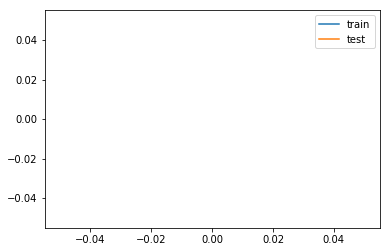

In [157]:
plt.plot(train_metrics_df.groupby("alpha_log")["accuracy"].mean(), label="train")
plt.plot(test_metrics_df.groupby("alpha_log")["accuracy"].mean(), label="test")
plt.legend()

In [158]:
train_metrics_df.sort_values("c")

,alpha,beta,c,accuracy,alpha_log
0,0,100.0,0.012454,0.000755,-inf
1,0,200.0,0.017683,0.000762,-inf
2,0,300.0,0.021688,0.000764,-inf
3,0,400.0,0.025061,0.000766,-inf
4,0,500.0,0.028031,0.000766,-inf
5,0,600.0,0.030715,0.000767,-inf
6,0,700.0,0.033184,0.000767,-inf
7,0,800.0,0.035480,0.000767,-inf
8,0,900.0,0.037637,0.000767,-inf
9,0,1000.0,0.039677,0.000767,-inf


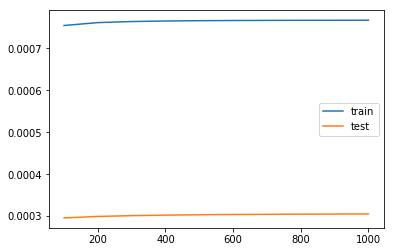

In [159]:
plt.plot(train_metrics_df.groupby("beta")["accuracy"].max(), label="train")
plt.plot(test_metrics_df.groupby("beta")["accuracy"].max(), label="test")
plt.legend()

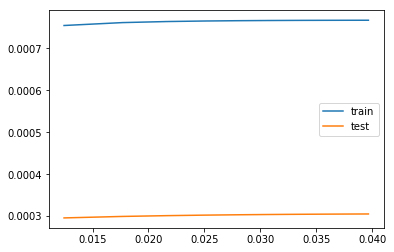

In [160]:
plt.plot(train_metrics_df.groupby("c")["accuracy"].max(), label="train")
plt.plot(test_metrics_df.groupby("c")["accuracy"].max(), label="test")
plt.legend()

# Ручная проверка

In [420]:
train_showtime = train.copy()

In [427]:
train_showtime

value  \
from                                       to                                                  
0x0000000000000000000000000000000000000000 0x28a3da09a8194819ae199f2e6d9d1304817e28a5      1   
                                           0xc2836188d9a29253e0cbda6571b058c289a0bb32      1   
0x00000f9ec07c056730188b975ead364e253547fa 0xecf07ef0b6c1522d6c9f668a36f00213036681e5      1   
0x0000985c020fdb2ae61bd7b7a7daca9c2ea047e3 0x9997460531a74a034ff314291e6b6adaef6073ff      1   
0x00009fd1e72f1a635a13a8e4177c697886033ba7 0x4c5c4e1437fc4106f50f40c38878681236b9c12d      1   
0x000171391e7679119cd1811548b9c8c25b6657d0 0x9af8bb6fe0bc253071e92c8cefbe41ebe5abb817      1   
0x0003117510b77b71765b6af931c116f327086f90 0x18adc5cfca4bdee8762e3b333f940fb954461929      1   
0x000438f1de357e597b457decc8bf91964451518b 0x9c927028a91a95a4af841d1feab2de9fbee8c4c4      1   
0x0004c0718b46740eb42b69475db2221e9bb85376 0x8e9a0ad56287e689dc80c27a64fd31e3c4c31373      1   
0x0004db3ed0a60659bf24af1517d245dd7ef75c2c 0x5baeac0a0417a05733884852aa068b706967e790      1   
0x00051d5dba85fb5488f2051b314cee770fb31fff 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x0005842198450f7e51cefa4e609765696a59b29b 0xd2fc3c32c0b25fd950059978fc03f3fde6c960bb      1   
0x000610cbcd54b2ac4a9656ec71eabe75b28fe96d 0x51f65ac6f4361c0dfc34f6ba5cd7ff605a1eb6b3      1   
0x00061c585215fd29a13454262dbddafed6518e05 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89 0x6090a6e47849629b7245dfa1ca21d94cd15878ef      1   
0x0006bf729369e195145d7078038fa816ae07262c 0x2bb66c530704653fe5efff9f56c208e35be4a63f      1   
0x000761de31b1c5a929d66f6851423ca6a7468fd5 0x0b95993a39a363d99280ac950f5e4536ab5c5566      2   
0x0007dbd56862a42c87af88ab1f4e32fe72823a8b 0xc715748df02c8f32412bba8f1607ce1bfe740a74      1   
0x00081af78944770f74302d3c685dfdb55ca75ffc 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x0008831df723b3064cfc9cbf6bb11f875adb0f16 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x0008f1cbd42286d09e79df38fce907a6c89968a6 0x12444b6ec62e616ebc8a23e56e61f8f4c6da610c      1   
0x00094eb0d46d0465296ab3994c9c34c634bed57d 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x0009cbf26fa8f20f06c63bffb83f93ae49b832a9 0xfa52274dd61e1643d2205169732f29114bc240b3      1   
0x000a8076834dbc2edca1d7692775b6eeca08ee77 0xba11f50e3b3f6ee0e6bae1df5b936570addce24e      1   
0x000af4918b635503689da522d2aeffb7c9bc0f4e 0x0b95993a39a363d99280ac950f5e4536ab5c5566      3   
0x000af6937ff1fd592d53eb5db2d9eb7855bfcc26 0x0b95993a39a363d99280ac950f5e4536ab5c5566      1   
0x000bf0664e5c3e321cd62d83fe6ecf14651de125 0x1303aa3ead0401b55c140b2d8a7eed7fe338a79e      1   
                                           0xf9c6ff62ad50e93652780decec989c7d1cbd4f0e      1   
0x000c700ad310fac642e873e5c86375d8ca9e040f 0x7415c7bf3e2415fa9a55f1fd8b6fccf2914c39a6      1   
0x000d4b94db7dd666b8a6bc445798b211a042abc8 0x015552a658bfe445a3da01c74f6b01d4c84c1476      1   
...                                                                                      ...   
0xffc81c3ce2d090259126ea41f5553de630790166 0x56eb83949fdf543e8cee4569739d21f07e4eafa9      1   
0xffc9983d978ca34a7fedd569bec403068b7f8200 0xd772b4707e8c7b3c602594adcde4e0a28d97ff3c      1   
0xffcac667b14280a9be3cdeca11942a0210c4ceb9 0x9b163e051b820e651c63944ce5de9002774bae5b      1   
0xffcb304e3d8727ac93e914db8fa2d4214973f3d9 0xb51b7454273118990c7599bdb54055cb2df8ca20      1   
0xffce56001335560e765f66ef45a98cf2b00070bc 0x61c22d6953d0ce270a98ef7737ce3b86e510b758      1   
0xffd21afda11c65e3cccb2bc544e0c9f35a74e7c8 0x92a2ede8b85e592e2e8c0dfc04e14c4ae9480240      1   
0xffd53c6654dedc39184a418c2eccbf2811763707 0xb2913ac117ab9e28c91a3dda479ac271765c4631      1   
0xffd82a90a0d1e2d58d2dfd1c04deb826cba689d0 0x3be1908e493327dcace2dd38c7f83e30813b87fa      1   
0xffda43bb7f5f7ad17215f4d2efb07181127146ac 0xffda43bb7f5f7ad17215f4d2efb07181127146ac      1   
0xffda94636747d3305912873d32ff31e364961409 0xfbb1b73c4f

In [418]:
accuracy(train_showtime, train_showtime["direction_probability"].tolist(), train_showtime["number_of_edges"].tolist())

0.49731028361405405

In [429]:
accuracy(train_showtime, train_showtime["direction_probability"].tolist(), train_showtime["number_of_edges"].tolist())

0.6555236015738831

In [430]:
train_showtime["prediction"] = train_showtime["direction_probability"] * train_showtime["number_of_edges"]

In [462]:
train_showtime["number_of_edges"].max()

1.4999999925556873

In [446]:
((train_showtime["value"] - train_showtime["prediction"]) ** 2).sort_values(ascending=True).head(30000)

from                                        to                                        
0x0fd081e3bb178dc45c0cb23202069dda57064258  0x8c99da965629c43bd278e25e7959a96f70fdb89b    1.197272e-07
0xb500a1429000ae315717390a052371ffbea59b5c  0x3839416bd0095d97be9b354cbfb0f6807d4d609e    1.345664e-05
0x00a183fdbebce39cc1065b14b1015cea3b40b651  0x3839416bd0095d97be9b354cbfb0f6807d4d609e    1.345664e-05
0x9937e86d5af7b782ba77b535ab075c7d54813771  0x048717ea892f23fb0126f00640e2b18072efd9d2    1.577634e-05
0xf73c3c65bde10bf26c2e1763104e609a41702efe  0x9e75f8a3698ba5f924aad561488e052078b23eda    3.683858e-05
0x1c0d39bb7511653bd2ebea5b4d85608a908ed9f7  0x70bc08efb79c65cd1035f20ecaa124107824572a    5.573184e-05
0x46ac3404a54b3eaf8d3ea687a87eac3bbfb1bd40  0x8bfe5ebb128ee82f4ba80f56bb32409cc87bc6fb    6.079338e-05
0x6fe872e753e1835d7f72ad2942d5a52eeb9b3dde  0x8bfe5ebb128ee82f4ba80f56bb32409cc87bc6fb    6.079338e-05
0x1f2dbb3963257cd90a9b834424690b127cb2b2da  0x8bfe5ebb128ee82f4ba80f56bb32409cc87bc6fb   

Как влияет параметр b на предсказания дуг?

In [354]:
train_predictions

[1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.5097618538803377,
 1.4983119847434916,
 1.4788900742767328,
 1.52233873297785,
 1.52233873297785,
 1.52233873297785,
 1.52233873297785,
 1.5153702480820765,
 1.5222236850639679,
 1.513524216530937,
 1.5221649454468187,
 1.513744149605922,
 1.4648640319063257,
 1.513524216530937,
 1.5212319984445883,
 1.5026188467226878,
 1.4976413413571394,
 1.521729545247866,
 1.521729545247866,
 1.521729545247866,
 1.513524216530937,
 1.5223681137424168,
 1.5223681137424168,
 1.5223